# Lowell Digisonde Reader
This notebook is a tool to read and plot data from the Lowell Digisonde network: https://www.digisonde.com/

Follow the Rules of the Road! https://giro.uml.edu/didbase/RulesOfTheRoad.html

In [39]:
import urllib
import pandas as pd
import plotly.express as px
import wget
import os                                      # for making sure we have a directory to write data to


# Generate output directories:
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('plots'):
    os.makedirs('plots')

## Read Station List


In [40]:
stations = pd.read_csv('DIDBASE List.csv')
stations = stations.set_index('URSI')

## Map stations

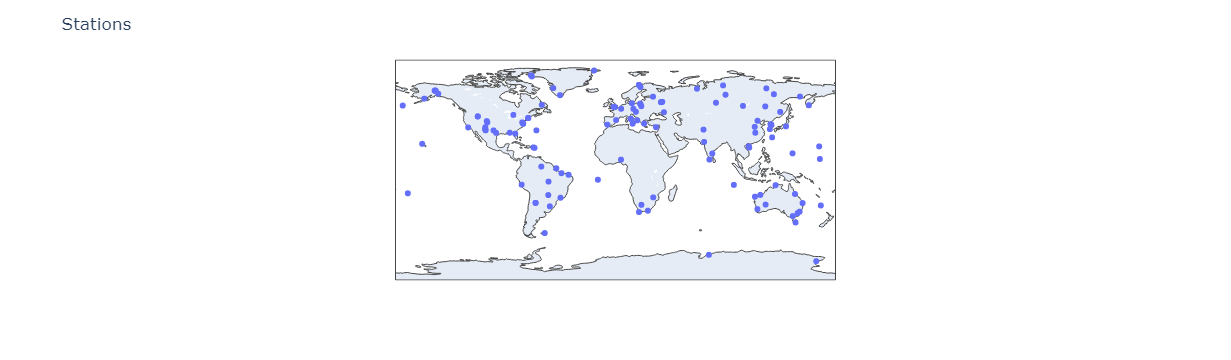

In [41]:
# Map nodes:
fig = px.scatter_geo(stations, "LAT", "LONG",
#                      color="Status", # which column to use to set the color of markers
                     hover_name=stations["STATION NAME"], # column added to hover information
                     hover_data=[stations.index], 
                     )
fig.update_layout(title="Stations")
fig.show()
fig.write_html("ionosonde_map.html", include_plotlyjs="cdn")

## Functions to read data: 

### Construct URL
Example: https://lgdc.uml.edu/common/DIDBGetValues?ursiCode=BC840&charName=hmE&fromDate=2020.01.29&toDate=2020.01.30

In [42]:
# url = "https://lgdc.uml.edu/common/DIDBGetValues?ursiCode=BC840&charName=hmE&fromDate=2020.01.29&toDate=2020.01.30"

import requests

# Parameters:
    # f0F2 f0F1 MD (MUF(D) /foF2) fmin f0ES fminF fminE foE fxI hF hF2 hE hEs hmE yE QF QE FF FE
    # hmF2 hmF1 zhalfNm finEs yF2 yF2 TEC scaleF2 (scale height at F2 peak) B0 B1 D1 f0Ea
    # hEa foP hP fbEs TypeEs

def urlmaker(URSIcode, parameter, fromDate, toDate):
    URL = 'http://lgdc.uml.edu/common/DIDBGetValues' + \
      '?ursiCode=' + URSIcode + \
      '&charName=' + parameter + \
      '&fromDate=' + fromDate + \
      '&toDate='   + toDate
    return URL


url = urlmaker(URSIcode = 'BC840', parameter = 'hmE', fromDate = '2020.01.29', toDate = '2020.01.30')
url

'http://lgdc.uml.edu/common/DIDBGetValues?ursiCode=BC840&charName=hmE&fromDate=2020.01.29&toDate=2020.01.30'

### Read URL data

In [43]:
def didread(url):
    file = urllib.request.urlopen(url)

    id = []                                                     # commented lines
    ego = []                                                    # get it? as opposed to "id"? (I'm tired.)
    for line in file:
        decoded_line = line.decode("utf-8")
        if decoded_line.startswith("#"):
    #         print(decoded_line)
            id.append(decoded_line)
        else:
            ego.append(decoded_line.split())
    id                                                          # print header information

    headers = id[len(id)-1]                                     # Pull headers from url file
    headers.split()                                             
    df = pd.DataFrame(ego)                                      # Create dataframe
    df.columns = headers.split()
    df=df.rename(columns = {'#Time':'Time'})                    # Fix column name
    df['Time'] = pd.to_datetime(df['Time'])                     # Cast timestamp to datetime
    return df

### Plot data from multiple ionosondes for a given date and parameter:

First, set your parameters of interest in this cell:

In [44]:
# This stuff's not going to change from station to station:
parameter = 'hmF2'
fromDate = '2022.10.24' 
toDate = '2022.10.25'
cadence = '1T'                                      # '5T' is a 5 minute cadence

# Let's confine our search to just a couple of stations. Comment this line out if you want to see ALL of them. 
# stations = stations.loc[stations['STATION NAME'].isin(['AUSTIN','BOULDER'])]

In [45]:
#  Alternatively, we can just look at stations that are in and around the continental United States:
NSEW = [80, 20, -120+360, -60+360] # north, south, east, west bounds 
stations = stations.loc[(stations['LAT']<NSEW[0]) & (stations['LAT']>NSEW[1]) & (stations['LONG']>NSEW[2]) & (stations['LONG']<NSEW[3])].copy()

In [46]:
# How to generate df for a single station and set of parameters:
# df = didread(urlmaker(URSIcode = 'BC840', parameter = 'hmE', fromDate = '2020.01.29', toDate = '2020.01.30'))

# Preallocation:
df = didread(urlmaker(URSIcode = 'AT138', parameter = parameter, fromDate = fromDate, toDate = toDate))
df = df.drop(columns = ['CS', 'QD'])
df['Time']= pd.to_datetime(df['Time']) # cast to datetime
df = df.set_index('Time')
pd.DataFrame.resample(df, cadence)


# Iterating through all the ionosondes: 
for station in stations.index:
    try:
        df1 = didread(urlmaker(URSIcode = station, parameter = parameter, fromDate = fromDate, toDate = toDate))
        foo = stations.loc[stations.index==station]
        df1 = df1.rename(columns = {str(parameter):foo.iloc[0, 1]})
        df1 = df1.drop(columns = ['CS', 'QD'])
        
        df1['Time']= pd.to_datetime(df1['Time']) # cast to datetime
        df1 = df1.set_index('Time')
        pd.DataFrame.resample(df1, cadence)
#         df1 = df1.sort_values(by="Time")        # not sure this line actually does anything...
        
        print('Merging data...' + station +": " + foo.iloc[0, 1])
#         df1 = df1.sort_values(by="Time")
        df = pd.merge(df, df1, on = 'Time', how='outer')  
#         df = pd.join(df, df1)
    except:
        continue

df = df.drop(columns = [str(parameter)])                          # stone soup
# df = df.set_index('Time')
# df = df.sort_values(by="Time")

print('\nHere is the ' + str(parameter) + ' data you requested:')
df

Merging data...AL945: ALPENA
Merging data...AU930: AUSTIN
Merging data...BC840: BOULDER
Merging data...EG931: EGLIN AFB
Merging data...IF843: IDAHO NATIONAL LAB
Merging data...MHJ45: MILLSTONE HILL
Merging data...THJ76: THULE
Merging data...WP937: WALLOPS IS

Here is the hmF2 data you requested:


,ALPENA,AUSTIN,BOULDER,EGLIN AFB,IDAHO NATIONAL LAB,MILLSTONE HILL,THULE,WALLOPS IS
Time,,,,,,,,
2022-10-24 00:00:00+00:00,296.8,NaN,NaN,253.8,252.4,289.7,319.7,NaN
2022-10-24 00:05:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-24 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-24 00:15:00+00:00,294.9,NaN,NaN,253.5,285.0,324.1,385.1,NaN
2022-10-24 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-10-24 23:30:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.8
2022-10-24 23:35:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.6
2022-10-24 23:40:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.6


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1469 entries, 2022-10-24 00:00:00+00:00 to 2022-10-24 23:55:08+00:00
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ALPENA              182 non-null    float64
 1   AUSTIN              284 non-null    float64
 2   BOULDER             276 non-null    float64
 3   EGLIN AFB           181 non-null    float64
 4   IDAHO NATIONAL LAB  91 non-null     float64
 5   MILLSTONE HILL      164 non-null    float64
 6   THULE               162 non-null    float64
 7   WALLOPS IS          279 non-null    float64
dtypes: float64(8)
memory usage: 103.3 KB
None


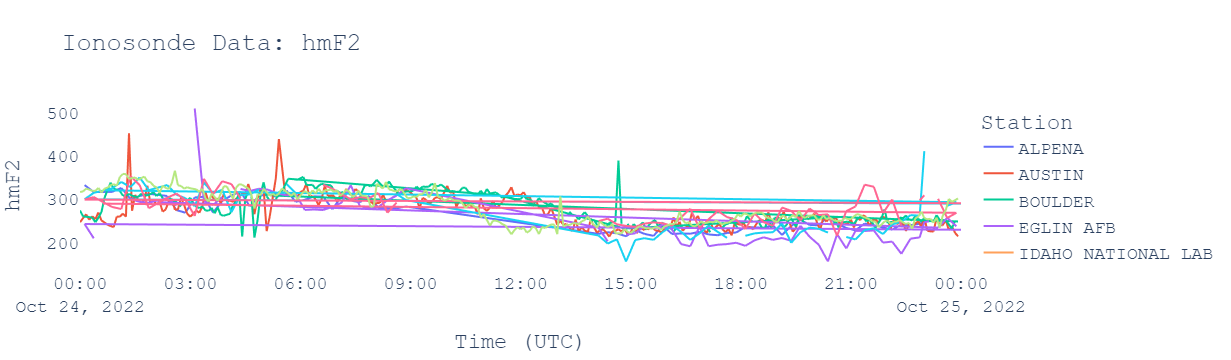

In [49]:
# Generate an interactive plot
# df = df.sort_values(by="Time")  # This seems to break the plot for some reason.

# Convert to numeric so plotly express can plot the data correctly:
df[df.columns] = df[df.columns].apply(pd.to_numeric)

print(df.info())     # for debugging:


fig = px.line(df, title=str(parameter))  # Use px.line or px.scatter, according to your preference.


fig.update_layout(autotypenumbers='convert types')     # converting to fix plotting


fig.update_layout(
    title="Ionosonde Data: " + str(parameter),
    xaxis_title="Time (UTC)",
    yaxis_title=str(parameter),
    legend_title="Station",
    font=dict(
        family="Courier New, monospace",
        size=18,
#         color="RebeccaPurple"
    )
)

# Eliminate the gray background plotly express uses by default:
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

fig.show()
fig.write_html("plots/"+ str(parameter) + "_plot.html", include_plotlyjs="cdn")


In [48]:
# # Comment in to write dataframe to CSV:
df.to_csv('data/' + str(parameter) + '.csv')